# Multi-Layer Perceptron (MLP) Example

In [34]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob, os
import random

import tensorflow as tf
from tensorflow import keras

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
try:
    for kgpu in range(len(physical_devices)):
        tf.config.experimental.set_memory_growth(physical_devices[kgpu], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

[]


## Build data pipeline

### input and output variable list
- Note that ptend_t and ptend_q0001 are not in the output (mlo) netcdf files, but calculated real-time on a tf Dataset object.
- Variable list: https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0

In [35]:
# in/out variable lists
vars_mli = ['state_t','state_q0001','state_ps','pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX']
vars_mlo = ['ptend_t','ptend_q0001','cam_out_NETSW','cam_out_FLWDS','cam_out_PRECSC','cam_out_PRECC','cam_out_SOLS','cam_out_SOLL','cam_out_SOLSD','cam_out_SOLLD']

## tf Dataset pipeline
- ref: https://www.noahbrenowitz.com/post/loading_netcdfs/
- ref: https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [36]:
norm_path = "/home/alvarovh/code/cse598_climate_proj/ClimSim/preprocessing/normalizations/"
root_train_path = "/nfs/turbo/coe-mihalcea/alvarovh/climsim/climsim_lowres_twomonths/datasets--LEAP--ClimSim_low-res/snapshots/bab82a2ebdc750a0134ddcd0d5813867b92eed2a/train"

In [37]:
mli_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
mli_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
mli_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
mlo_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

In [38]:

def load_nc_dir_with_generator(filelist:list):
    def gen():
        for file in filelist:
            
            # read mli
            ds = xr.open_dataset(file, engine='netcdf4')
            ds = ds[vars_mli]
            
            # read mlo
            dso = xr.open_dataset(file.replace('.mli.','.mlo.'), engine='netcdf4')
            
            # make mlo variales: ptend_t and ptend_q0001
            dso['ptend_t'] = (dso['state_t'] - ds['state_t'])/1200 # T tendency [K/s]
            dso['ptend_q0001'] = (dso['state_q0001'] - ds['state_q0001'])/1200 # Q tendency [kg/kg/s]
            dso = dso[vars_mlo]
            
            # normalizatoin, scaling
            ds = (ds-mli_mean)/(mli_max-mli_min)
            dso = dso*mlo_scale

            # stack
            #ds = ds.stack({'batch':{'sample','ncol'}})
            ds = ds.stack({'batch':{'ncol'}})
            ds = ds.to_stacked_array("mlvar", sample_dims=["batch"], name='mli')
            #dso = dso.stack({'batch':{'sample','ncol'}})
            dso = dso.stack({'batch':{'ncol'}})
            dso = dso.to_stacked_array("mlvar", sample_dims=["batch"], name='mlo')
            
            yield (ds.values, dso.values)

    return tf.data.Dataset.from_generator(
        gen,
        output_types=(tf.float64, tf.float64),
        output_shapes=((None,124),(None,128))
    )

## Instantiate tf.data.Dataset object here
- Dataset file size and dimensions: https://docs.google.com/document/d/1HgfZZJM0SygjWvSAJ5kSfql9aXUFkvLybL36p-vmdZc/edit

In [39]:
import random
import glob

# Parameters for debugging
train_file_limit = 200  # Number of files to use for training
val_proportion = 0.1    # Percentage of training data used for validation

# Training files from year 0001, month 02
f_mli = glob.glob(root_train_path + '/0002-01/E3SM-MMF.mli.0002-01-*.nc')
random.shuffle(f_mli)

# Apply the limit to the training files
f_mli = f_mli[:train_file_limit]
print(f'[TRAIN] Total # of input files after applying limit: {len(f_mli)}')

# Load and prepare the training dataset
tds = load_nc_dir_with_generator(f_mli)
tds = tds.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=True)
tds = tds.prefetch(buffer_size=4)

# Validation files from year 0002, month 02
# Using 10% of the training files as validation
f_mli_val = f_mli[:int(train_file_limit * val_proportion)]
print(f'[VAL] Total # of input files for validation (10% of training): {len(f_mli_val)}')

# Load and prepare the validation dataset
tds_val = load_nc_dir_with_generator(f_mli_val)
tds_val = tds_val.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=True)
tds_val = tds_val.prefetch(buffer_size=4)


[TRAIN] Total # of input files after applying limit: 200
[VAL] Total # of input files for validation (10% of training): 20


In [40]:
# shuffle_buffer=384*12

# # for training

# # # First 5 days of each month for the first 6 years
# # f_mli1 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.000[123456]-*-0[12345]-*.nc')
# # f_mli2 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.0007-01-0[12345]-*.nc')
# # f_mli = [*f_mli1, *f_mli2]

# # every 10th sample
# f_mli1 = glob.glob(root_train_path + '/*/E3SM-MMF.mli.000[123456]-*-*-*.nc')
# f_mli2 = glob.glob(root_train_path + '/*/E3SM-MMF.mli.0007-01-*-*.nc')
# f_mli = sorted([*f_mli1, *f_mli2])
# random.shuffle(f_mli)
# f_mli = f_mli[::10]

# # # debugging
# # f_mli = f_mli[0:72*5]

# random.shuffle(f_mli)
# print(f'[TRAIN] Total # of input files: {len(f_mli)}')
# print(f'[TRAIN] Total # of columns (nfiles * ncols): {len(f_mli)*384}')
# tds = load_nc_dir_with_generator(f_mli)
# tds = tds.unbatch()
# tds = tds.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=True)
# tds = tds.prefetch(buffer_size=4) # in realtion to the batch size

# # for validation

# # # First 5 days of each month for the following 2 years
# # f_mli1 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.0007-0[23456789]-0[12345]-*.nc')
# # f_mli2 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.0007-1[012]-0[12345]-*.nc')
# # f_mli3 = glob.glob('/pscratch/sd/s/sungduk/hugging/E3SM-MMF_ne4/train/*/E3SM-MMF.mli.000[89]-*-0[12345]-*.nc')
# # f_mli_val = [*f_mli1, *f_mli2, *f_mli3]

# # every 10th sample
# f_mli1 = glob.glob(root_train_path + '/*/E3SM-MMF.mli.0007-0[23456789]-0[12345]-*.nc')
# f_mli2 = glob.glob(root_train_path + '/*/E3SM-MMF.mli.0007-1[012]-0[12345]-*.nc')
# f_mli3 = glob.glob(root_train_path + '/*/E3SM-MMF.mli.000[89]-*-0[12345]-*.nc')
# f_mli_val = sorted([*f_mli1, *f_mli2, *f_mli3])
# f_mli_val = f_mli_val[::10]

# # # debugging
# # f_mli_val = f_mli_val[0:72*5]

# random.shuffle(f_mli_val)
# print(f'[VAL] Total # of input files: {len(f_mli_val)}')
# print(f'[VAL] Total # of columns (nfiles * ncols): {len(f_mli_val)*384}')
# tds_val = load_nc_dir_with_generator(f_mli_val)
# tds_val = tds_val.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=True)
# tds_val = tds_val.prefetch(buffer_size=4) # in realtion to the batch size

# #list(tds)
# # for count_batch in tds.repeat().batch(10).take(1):
# #     print(count_batch[0].numpy())
# #count_batch[0].shape

## ML training
- While 4 GPUs are available on the node, using multi GPUs (with 'tf.distribute.MirroredStrategy()' strategy) does not speed up training process. It is possibly due to that the current Dataset pipeline is sequential.

In [41]:
tf.config.list_physical_devices('GPU')

[]

In [42]:
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():

# model params
input_length = 2*60 + 4
output_length_lin  = 2*60
output_length_relu = 8
output_length = output_length_lin + output_length_relu
n_nodes = 512

# constrcut a model
input_layer    = keras.layers.Input(shape=(input_length,), name='input')
hidden_0       = keras.layers.Dense(n_nodes, activation='relu')(input_layer)
hidden_1       = keras.layers.Dense(n_nodes, activation='relu')(hidden_0)
output_pre     = keras.layers.Dense(output_length, activation='elu')(hidden_1)
output_lin     = keras.layers.Dense(output_length_lin,activation='linear')(output_pre)
output_relu    = keras.layers.Dense(output_length_relu,activation='relu')(output_pre)
output_layer   = keras.layers.Concatenate()([output_lin, output_relu])

model = keras.Model(input_layer, output_layer, name='Emulator')
model.summary()

# compile
model.compile(optimizer=keras.optimizers.Adam(), #optimizer=keras.optimizers.Adam(learning_rate=clr),
              loss='mse',
              metrics=['mse','mae','accuracy'])

Model: "Emulator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 124)]                0         []                            
                                                                                                  
 dense_10 (Dense)            (None, 512)                  64000     ['input[0][0]']               
                                                                                                  
 dense_11 (Dense)            (None, 512)                  262656    ['dense_10[0][0]']            
                                                                                                  
 dense_12 (Dense)            (None, 128)                  65664     ['dense_11[0][0]']            
                                                                                           

In [43]:
# callbacks
# a. tensorboard
tboard_callback = keras.callbacks.TensorBoard(log_dir = './logs_tensorboard',
                                              histogram_freq = 1,)

# b. checkpoint
filepath_checkpoint = 'saved_model/best_model_proto.h5'
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=filepath_checkpoint,
                                                            save_weights_only=False,
                                                            monitor='val_mse',
                                                            mode='min',
                                                            save_best_only=True)

# c. csv logger
filepath_csv = 'csv_logger.txt'
csv_callback = keras.callbacks.CSVLogger(filepath_csv, separator=",", append=True)

my_callbacks= [tboard_callback, checkpoint_callback, csv_callback]

# !mkdir logs_tensorboard
# !mkdir saved_model

In [44]:
# Manually shuffling the order of input files.
# "tds = tds.shuffle(buffer_size=<global>, reshuffle_each_iteration=True)" is possible,
# however, it is slow.
# So employing global shuffle (by file names) + local shuffle (using .shuffle).

N_EPOCHS = 30
shuffle_buffer = 12*384 #ncol=384
batch_size= 96 # 384/4

n=0
while n < N_EPOCHS:
    random.shuffle(f_mli)
    tds = load_nc_dir_with_generator(f_mli) # global shuffle by file names
    tds = tds.unbatch()
 # local shuffle by elements    tds = tds.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=False)
    tds = tds.batch(batch_size)
    tds = tds.prefetch(buffer_size=int(shuffle_buffer/384)) # in realtion to the batch size

    random.shuffle(f_mli_val)
    tds_val = load_nc_dir_with_generator(f_mli_val)
    tds_val = tds_val.unbatch()
    tds_val = tds_val.shuffle(buffer_size=shuffle_buffer, reshuffle_each_iteration=False)
    tds_val = tds_val.batch(batch_size)
    tds_val = tds_val.prefetch(buffer_size=int(shuffle_buffer/384))
    
    print(f'Epoch: {n+1}')
    model.fit(tds, 
              validation_data=tds_val,
              callbacks=my_callbacks)
    
    n+=1

Epoch: 1
800/800 [==============================] - 41s 50ms/step - loss: 0.0058 - mse: 0.0058 - mae: 0.0328 - accuracy: 0.9544 - val_loss: 0.0048 - val_mse: 0.0048 - val_mae: 0.0293 - val_accuracy: 0.9656


/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 2
800/800 [==============================] - 17s 21ms/step - loss: 0.0048 - mse: 0.0048 - mae: 0.0280 - accuracy: 0.9624 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0267 - val_accuracy: 0.9660


/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 3
800/800 [==============================] - 17s 21ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0268 - accuracy: 0.9661 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0258 - val_accuracy: 0.9673


/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 4
800/800 [==============================] - 17s 21ms/step - loss: 0.0045 - mse: 0.0045 - mae: 0.0261 - accuracy: 0.9665 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0249 - val_accuracy: 0.9660


/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 5
800/800 [==============================] - 17s 21ms/step - loss: 0.0044 - mse: 0.0044 - mae: 0.0256 - accuracy: 0.9675 - val_loss: 0.0045 - val_mse: 0.0045 - val_mae: 0.0259 - val_accuracy: 0.9668
Epoch: 6
800/800 [==============================] - 17s 21ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0252 - accuracy: 0.9677 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0247 - val_accuracy: 0.9669
Epoch: 7
800/800 [==============================] - 17s 21ms/step - loss: 0.0043 - mse: 0.0043 - mae: 0.0248 - accuracy: 0.9686 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0243 - val_accuracy: 0.9703


/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 8
800/800 [==============================] - 17s 21ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0246 - accuracy: 0.9694 - val_loss: 0.0042 - val_mse: 0.0042 - val_mae: 0.0243 - val_accuracy: 0.9669
Epoch: 9
800/800 [==============================] - 17s 21ms/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0243 - accuracy: 0.9696 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0244 - val_accuracy: 0.9672
Epoch: 10
800/800 [==============================] - 17s 21ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0241 - accuracy: 0.9704 - val_loss: 0.0043 - val_mse: 0.0043 - val_mae: 0.0246 - val_accuracy: 0.9690
Epoch: 11
    797/Unknown - 15s 19ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0239 - accuracy: 0.9715

/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


800/800 [==============================] - 17s 22ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0239 - accuracy: 0.9715 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0238 - val_accuracy: 0.9704
Epoch: 12
800/800 [==============================] - 17s 21ms/step - loss: 0.0041 - mse: 0.0041 - mae: 0.0239 - accuracy: 0.9713 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0234 - val_accuracy: 0.9730


/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 13
800/800 [==============================] - 17s 21ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0237 - accuracy: 0.9709 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0233 - val_accuracy: 0.9661
Epoch: 14
800/800 [==============================] - 17s 21ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0235 - accuracy: 0.9716 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0230 - val_accuracy: 0.9711


/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 15
    797/Unknown - 15s 19ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0234 - accuracy: 0.9719

/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


800/800 [==============================] - 17s 21ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0234 - accuracy: 0.9718 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0232 - val_accuracy: 0.9719
Epoch: 16
800/800 [==============================] - 17s 21ms/step - loss: 0.0040 - mse: 0.0040 - mae: 0.0233 - accuracy: 0.9729 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0232 - val_accuracy: 0.9711
Epoch: 17
800/800 [==============================] - 17s 21ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0233 - accuracy: 0.9721 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0230 - val_accuracy: 0.9724
Epoch: 18
800/800 [==============================] - 17s 21ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0232 - accuracy: 0.9726 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0229 - val_accuracy: 0.9723


/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 19
800/800 [==============================] - 17s 21ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0231 - accuracy: 0.9726 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0234 - val_accuracy: 0.9677
Epoch: 20
800/800 [==============================] - 17s 21ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0230 - accuracy: 0.9729 - val_loss: 0.0039 - val_mse: 0.0039 - val_mae: 0.0232 - val_accuracy: 0.9730
Epoch: 21
    797/Unknown - 15s 19ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0230 - accuracy: 0.9730

/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


800/800 [==============================] - 19s 23ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0230 - accuracy: 0.9731 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0227 - val_accuracy: 0.9738
Epoch: 22
800/800 [==============================] - 17s 21ms/step - loss: 0.0039 - mse: 0.0039 - mae: 0.0229 - accuracy: 0.9735 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0227 - val_accuracy: 0.9753
Epoch: 23
800/800 [==============================] - 17s 21ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0228 - accuracy: 0.9741 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0229 - val_accuracy: 0.9733
Epoch: 24
800/800 [==============================] - 17s 21ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0227 - accuracy: 0.9738 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.0226 - val_accuracy: 0.9746
Epoch: 25
800/800 [==============================] - 17s 21ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0227 - accuracy: 0.9736 - val_loss: 0.0038 - val_mse: 0.0038 - val_mae: 0.022

/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 28
800/800 [==============================] - 17s 21ms/step - loss: 0.0038 - mse: 0.0038 - mae: 0.0226 - accuracy: 0.9741 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0227 - val_accuracy: 0.9764
Epoch: 29
800/800 [==============================] - 17s 21ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0225 - accuracy: 0.9752 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0224 - val_accuracy: 0.9753


/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 30
800/800 [==============================] - 17s 21ms/step - loss: 0.0037 - mse: 0.0037 - mae: 0.0225 - accuracy: 0.9752 - val_loss: 0.0037 - val_mse: 0.0037 - val_mae: 0.0223 - val_accuracy: 0.9755


/home/alvarovh/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
pwd

'/home/alvarovh'

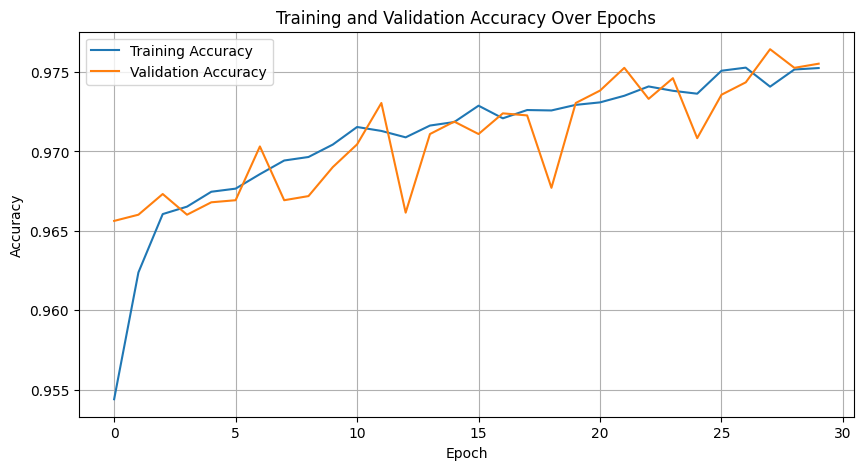

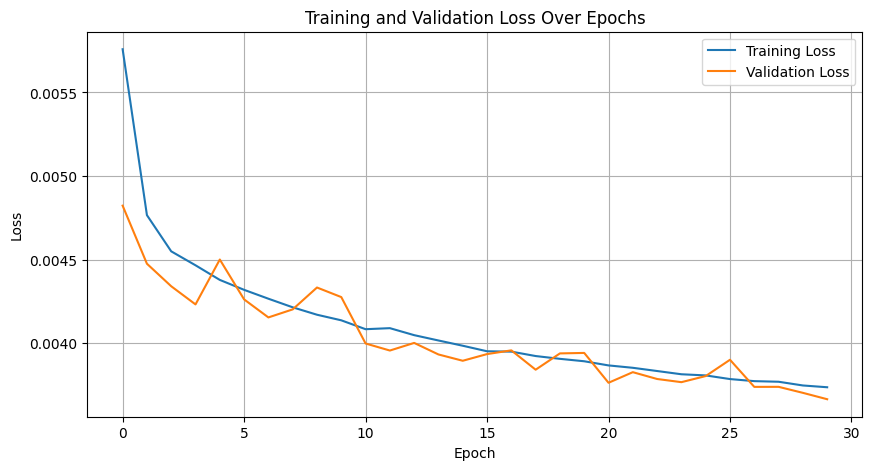

In [46]:
# Here's the modified code to load data from a CSV file by specifying the file path

import pandas as pd
import matplotlib.pyplot as plt

# Replace 'your_file_path.csv' with the path to your CSV file
file_path = '/home/alvarovh/csv_logger.txt'

# Load the data from the specified file path
df = pd.read_csv(file_path)

# Plotting accuracy and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['accuracy'], label='Training Accuracy')
plt.plot(df.index, df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting loss and validation loss
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['loss'], label='Training Loss')
plt.plot(df.index, df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
